# DistilBERT

This project aims to support students who are beginning their journey in text analysis. Our main goal is to help them build language applications using Hugging Face and natural language processing with transformers.

## Statistical Analyses on Texts

The text analyses presented here are based on datasets available on the Hugging Face Hub (https://oreil.ly/959YT).

For the analyses we will develop here, we use the dataset available at https://huggingface.co/datasets/dair-ai/emotion.

#### Importing libraries

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import list_datasets


import os
import sys

sys.stderr = open(os.devnull, 'w')  


#### Importing the dataset

In [9]:
print('--- Download starting ---')
emotions = load_dataset('emotion')
print("--- Download Completed ---")
emotions

--- Download starting ---
--- Download Completed ---


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Note that, the dataset is a dictionary partitioned between `train`, `test` and `validation`. 

We can use the usual dictionary syntax to acess an individual split.

In [3]:
X_train = emotions['train']
print(f'The length of the dataset train is {len(X_train)}')

# If we want to access the first information, we can do:
print(f'The first information is {X_train[0]}')

# If we want to see the column names, we can do:
print(f'The column names are {X_train.column_names}')

# If we want to see the attribute of dataset object, we can do:
print(f'Theattribute of dataset object are {X_train.features}')


The length of the dataset train is 16000
The first information is {'text': 'i didnt feel humiliated', 'label': 0}
The column names are ['text', 'label']
Theattribute of dataset object are {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


To develop our analyses, we will convert the dataset into a DataFrame.

In [4]:
emotions.set_format(type='pandas')
df_train = emotions['train'][:]
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


The column headers have been preserved, and the first few rows match our previous view of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the label feature to create a new column in our DataFrame with the corresponding label names.

In [13]:
def input_label(row):
    return emotions['train'].features['label'].int2str(row)

# Applying the function
df_train['label_name'] = df_train['label'].apply(input_label)
df_train.head()

,id,sentence,label,label_name
0,1,Huzza! Huzza! cried the Court; and the little ...,0,joy
1,2,"'I am no son of thine, for thou art a beggar, ...",1,sadness
2,3,"Conversation, indeed! said the Rocket.",8,other
3,4,"It was the farthest corner of the garden, and ...",1,sadness
4,5,"And at last he spoke to her, and his voice was...",2,anger


Let's check the class distribution

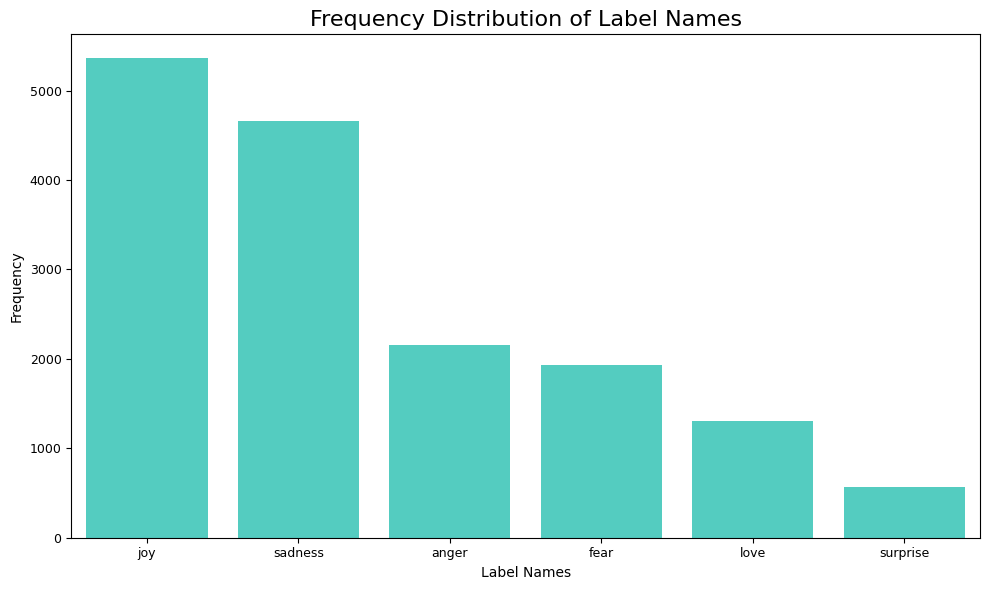

In [6]:
# Count the frequency of values in 'label_name'
label_counts = df_train['label_name'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, color='#40E0D0')
# Customize the chart
plt.title("Frequency Distribution of Label Names", fontsize=16)
plt.xlabel("Label Names", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Show the chart
plt.tight_layout()
plt.show()


Obviously, there are imbalanced classes: for example, **surprise**, **love**, **fear** and **anger**  are minority classes compared to **joy** and **suprise**.

At the present moment, we are working with imbalanced classes. If necessary, we will adjust the classes.

**Note**: For applications using DistilBERT, the maximum context size is $512$ tokens, wich amounts to a few paragraphs of text.

**Question:** Can we approximate tweet lengths for each emotion by analyzing the word distribution per tweet?

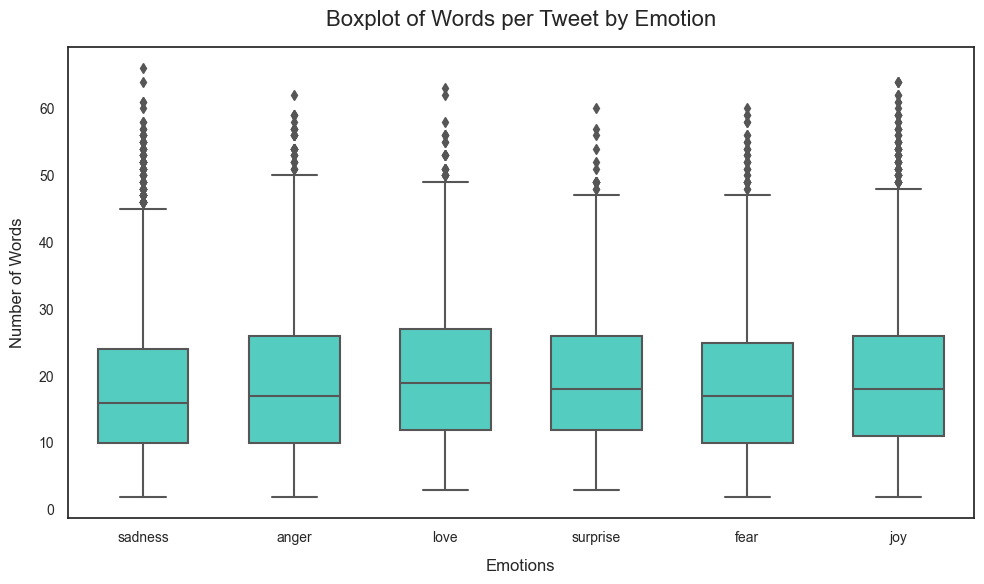

In [7]:
df_train['words_tweet'] = df_train['text'].str.split().apply(len)

sns.set_theme(style="white")  

# Create the improved boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='label_name', 
    y='words_tweet', 
    data=df_train, 
    color='#40E0D0',       
    showfliers=True,       
    width=0.6,             
    linewidth=1.5       
)

# Customize the title and labels
plt.title("Boxplot of Words per Tweet by Emotion", fontsize=16, pad=15)  
plt.xlabel("Emotions", fontsize=12, labelpad=10)                         
plt.ylabel("Number of Words", fontsize=12, labelpad=10)                  
plt.xticks(fontsize=10)                                                  
plt.yticks(fontsize=10)                                                  
plt.tight_layout()
plt.show()


Through the boxplot, we can see that for each emotion, the majority of tweets have around 15 words, and the other tweets are shorter than DistilBERT's maximum context size.
Texts longer than the model's context size must be truncated, which can result in performance degradation if the truncated text contains critical information. However, in this case, it does not appear to be an issue.

The next step is to transform the texts into tokens.

----

### What is a Token?

A **token** is a small piece of text that a computer can understand. When we give a sentence to a program, it breaks the sentence into smaller parts called tokens.

#### Examples:
1. **Full sentence:** "I like cats."
2. **Tokens (small parts):**
   - As words: `["I", "like", "cats"]`
   - As smaller pieces: `["I", "li", "ke", "ca", "ts"]`

The computer uses these tokens to turn text into numbers, because computers work with numbers, not words.

#### Why is this important?
Imagine teaching a robot to understand text. It can’t read full sentences like humans do. But if we split the sentence into tokens, the robot can learn what each piece means and how they connect to each other.

#### Simple Comparison:
Tokens are like puzzle pieces. Each piece alone doesn’t tell much, but when you put them together, they form the full picture (or the meaning of the text).


### Tokenization

The simplest tokenization method is to treat each character as a token and feed them individually to the model. In Python, `str` objects work like arrays internally, making it quick and easy to implement character-level tokenization.

Here is a simple example.

In [8]:
input_text = 'I love NLP.'
print(input_text)

tokenized_text = list(input_text)
print(tokenized_text)

I love NLP.
['I', ' ', 'l', 'o', 'v', 'e', ' ', 'N', 'L', 'P', '.']


All models expect each character to be converted into an integer, a process sometimes called **numericalization**.

We can perform **numericalization** as follows:

In [9]:
unique_chars = sorted(set(tokenized_text))
tokenized_idx = dict(zip(unique_chars, range(len(unique_chars))))
print(tokenized_idx)

{' ': 0, '.': 1, 'I': 2, 'L': 3, 'N': 4, 'P': 5, 'e': 6, 'l': 7, 'o': 8, 'v': 9}


Using **tokenized_idx** we can to transform the tokenized text to a list of integers. 

In [10]:
idx = [tokenized_idx[token] for token in tokenized_text]
print(idx)

[2, 0, 7, 8, 9, 6, 0, 4, 3, 5, 1]


Note that each token is associated with a unique numerical value. The final step is to convert the **idx** into a $2D$ tensor of one-hot encoded vectors.

### What is One-Hot Encoding?

A **one-hot encoded** representation is a way of converting categorical data (like words, characters, or labels) into a binary format that a machine learning model can process. It uses a vector where:

- **Only one position is 'hot' (1):** The position corresponding to the category is set to $1$.
- **All other positions are 'cold' (0):** All other positions are set to $0$.

#### Example

If you have three categories: `['cat', 'dog', 'fish']`, each one can be represented as a vector in a one-hot encoded format:

- `cat` → `[1, 0, 0]`
- `dog` → `[0, 1, 0]`
- `fish` → `[0, 0, 1]`

The index of `1` corresponds to the category's position in the list.

#### Why is it Useful?

1. **Machine learning models:** Models like neural networks work with numbers, not text, so one-hot encoding helps translate text into numerical input.

2. **No order imposed:** One-hot encoding ensures that categories are treated as equally distinct, with no implied order or hierarchy.


### What is a Tensor?

A **tensor** is a mathematical object that is a generalization of scalars, vectors, and matrices to higher dimensions. It’s the fundamental building block in many machine learning and deep learning frameworks, such as TensorFlow and PyTorch.

#### Examples of Tensors by Dimension

- **0D Tensor (Scalar):** A single number.  
  Example: $5$ or $3.14$
  
- **1D Tensor (Vector):** A one-dimensional array of numbers.  
  Example: `[1, 2, 3]`
  
- **2D Tensor (Matrix):** A two-dimensional array of numbers.  
  Example:  `[[1, 2, 3], [4, 5, 6]]`

- **3D Tensor:** A collection of matrices (like a cube of numbers).  
  Example: `[[[1, 2], [3, 4]], [[5, 6], [7, 8]]]`


- **nD Tensor:** Higher-dimensional arrays for more complex data representations.

#### Why are Tensors Important?

1. **Efficient Representation:**  
 Tensors allow us to represent and manipulate data of various shapes and dimensions in an efficient and structured way.

2. **Flexibility:**  
 Tensors can handle data like images, audio signals, or videos, which often require more than two dimensions.

3. **Foundation for Deep Learning:**  
 Operations like matrix multiplications, convolutions, and gradient calculations in neural networks are performed on tensors.

#### Analogy

Think of a tensor as a **generalized container** for data:
- A **0D tensor** is like a single number.
- A **1D tensor** is like a list of numbers (e.g., a shopping list).
- A **2D tensor** is like a spreadsheet.
- A **3D tensor** is like a stack of spreadsheets.

Tensors make it easy to store and process data for machine learning models.



In [11]:
import torch
import torch.nn.functional as F

# idx = [2, 0, 7, 8, 9, 6, 0, 4, 3, 5, 1]
idx = torch.tensor(idx)
one_hot_enconding = F.one_hot(idx, num_classes=len(idx))
print(one_hot_enconding.shape)
one_hot_enconding

torch.Size([11, 11])


tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

----

#### Explaning the output

Tensor:
[
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  $\to$ Represents index 2  
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  $\to$ Represents index 0  
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  $\to$ Represents index 7  
  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  $\to$ Represents index 8  
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  $\to$ Represents index 9  
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  $\to$ Represents index 6  
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  $\to$ Represents index 0  
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  $\to$ Represents index 4  
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  $\to$ Represents index 3  
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  $\to$ Represents index 5  
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]   $\to$ Represents index 1  
]

----

From the simple example, we see that character-level tokenization ignores the structure of the text, treating it as a sequence of characters. While it helps handle misspellings and rare words, it requires significant resources since linguistic structures like words need to be learned from scratch.

For this reason, character tokenization is rarely used. Instead, approaches like word tokenization preserve the structure of the text more efficiently.

### Word Tokenization

Unlike character-level tokenization, which breaks text into individual characters, word tokenization keeps words together, making it easier to understand and analyze text.  

This approach helps with tasks like sentiment analysis, topic modeling, and text classification by focusing on complete words. However, it also has challenges, such as handling contractions, punctuation, and language differences. In this chapter, we will look at how word tokenization works and how to use it in NLP.  

A simple way to tokenize words is by splitting text at spaces. This can be done easily using the `split()` function.

In [12]:
tokenized_text = input_text.split()
print(tokenized_text)

['I', 'love', 'NLP.']


From here, we can follow the same steps presented earlier and map each word to a unique $ID$.

A major limitation of this tokenization scheme is that it does not handle punctuation properly, treating terms like NLP as a single token. Additionally, variations such as declensions, conjugations, and misspellings can significantly expand the vocabulary, easily reaching millions of unique tokens.

### Subword Tokenization

Subword tokenization is a technique that splits text into units smaller than whole words but larger than individual characters. The core idea is to strike a balance between character-level and word-level tokenization by breaking words into meaningful subparts or subwords. This approach helps address the limitations of traditional word and character tokenization, making it particularly effective in modern Natural Language Processing (NLP) models.

### Principles of Subword Tokenization

#### Handling Rare Words:
- Instead of treating rare or unknown words as separate tokens, subword tokenization breaks them into smaller, more common subunits.
- **For example:**
  - Rare word: `'unhappiness'`
  - Subwords: `['un', 'happiness']`

#### Combining Efficiency and Flexibility:
- **Common words** are kept intact:  
  `'cat'` → `['cat']`
- **Uncommon or complex words** are split into smaller units:  
  `'internationalization'` → `['inter', 'national', 'ization']`
- This reduces the vocabulary size while still capturing meaningful linguistic information.

#### Dealing with Misspellings and Variants:
- Words with spelling errors or slight variations can share similar subword components, making models more robust to noise.
- **Example:**  
  `'color'` and `'colour'` may share subunits like `['col', 'or']`.

#### Vocabulary Efficiency:
- Subword tokenization significantly reduces the vocabulary size compared to word-level tokenization, as the model doesn’t need to memorize every single word in the language.


**Note:** There are several subword tokenization algorithms that are commoly used in NLP, but let's start with `WordPiece`, wich is used by DistilBERT tokenizers.

In [13]:
from transformers import AutoTokenizer
import torch


model_ckpt = 'distilbert-base-uncased' #the "uncased" version means that all letters will be treated as lowercase, ignoring case sensitivity.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) #Loads the tokenizer associated with the DistilBERT model.

The `AutoTokenizer` class is part of a broader family of **auto** classes designed to automatically retrieve a model's configuration, pretrained weights, or vocabulary based on the checkpoint name. This feature allows for seamless switching between models. However, if needed, you can also manually load a specific tokenizer class.

In [14]:
encoded_text = tokenizer(input_text)
# input_text = I love NLP.
print(encoded_text)

{'input_ids': [101, 1045, 2293, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


### Example for a Hypothetical Text

For the text `"I love NLP!"` (based on DistilBERT's vocabulary), the tokenized output is:

{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


#### Breakdown of `input_ids`:

- **101** $\to$ Special token `[CLS]`, added at the beginning of the text (we will explain this point).  
- **1045** $\to$ Token for `'I'`.  
- **2293** $\to$ Token for `'love'`.  
- **17953** $\to$ Token for `'NLP'`.  
- **2361** $\to$ Token for `'!'`.  
- **1012** $\to$ Token for `'.'` (period at the end of the sentence).  
- **102** $\to$ Special token `[SEP]`, added at the end of the text (we will explain this point).  


### `attention_mask`

The `attention_mask` indicates which tokens are relevant and should be processed by the model:

- **1** $\to$ Indicates a relevant token (part of the actual input text).
- **0** $\to$ Indicates an ignored token (e.g., padding).

In this case, all mask values are `1` because the text does not require padding. 


In [15]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'love', 'nl', '##p', '.', '[SEP]']


We can notice three key points here. First, special tokens like `[CLS]` and `[SEP]` have been added to the beginning and end of the sequence. These tokens vary across models, but their primary purpose is to mark the start and end of a sequence. Second, the tokens have been converted to lowercase, which is a characteristic of this specific checkpoint.

Lastly, we can see that **NLP** has been split into two tokens, which makes sense since it's not a common word. The prefix `##` in `##p` indicates that the preceding string has no whitespace. Any token with this prefix should be merged with the previous token when converting the tokens back into a string.

The **AutoTokenizer** class includes a `convert_tokens_to_string()` method specifically for this purpose. Let’s apply it to our tokens.

In [16]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i love nlp. [SEP]


Now that we have learned more about tokenization, we need to return to the initial dataset and carry out the tokenization.

----

#### Tokenizing the initial dataset

In [17]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples. The `padding=True` parameter ensures that the examples are padded with zeros to match the length of the longest example in the batch, while `truncation=True` limits the examples to the maximum context size supported by the model. To demonstrate how `__tokenize__()` works, let's process a batch containing two examples from the training set.

In [18]:
emotions['train'][:2][['text', 'label']]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0


In [19]:
print(tokenize({'text': emotions['train']['text'][:2].tolist()}))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here, we observe the effect of padding: the first element of `input_ids` is shorter than the second, so zeros were added to the first element to ensure both have the same length. These zeros correspond to the **[PAD]** token in the vocabulary. Additionally, the set of special tokens includes the **[CLS]** and **[SEP]** tokens we encountered earlier.

**Note:** In addition to returning the encoded tweets as `input_ids`, the tokenizer also provides a list of `attention_mask` arrays. These are essential because we want the model to focus only on the relevant parts of the input and ignore the padding tokens. The attention mask ensures the model does not consider the padded sections during processing.

For a deeper understanding of attention masks, we recommend this article: [Attention Mask](https://blog.lukesalamone.com/posts/what-are-attention-masks/?utm_source=chatgpt.com) or [Clarification on the Attention Mask](https://discuss.huggingface.co/t/clarification-on-the-attention-mask/1538?utm_source=chatgpt.com).

In [20]:
emotions.reset_format()

emotions_encoded = emotions.map(tokenize, batched=True,
                               batch_size=None)
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


DistilBERT, like other pretrained language models, is originally trained to predict masked words in a text sequence, a task known as **Masked Language Modeling (MLM)**. This process helps the model learn the context and structure of the language but is not directly applicable to text classification. To address this, the model needs to be modified by adding specific layers to transform the learned representations into label predictions. The classification task does not involve predicting masked words but rather mapping the entire text to specific categories, which explains the need for adjustments.


![Texto alternativo](foto_arquitetura.jpg)

The architecture for sequence classification in an encoder-based transformer consists of the model's pretrained body integrated with a custom classification layer.

First, the text is tokenized and converted into one-hot vectors, known as token encodings. The dimension of these encodings depends on the tokenizer’s vocabulary size, typically ranging from 20,000 to 200,000 unique tokens. These encodings are then mapped to token embeddings, which reside in a lower-dimensional space.

Next, the embeddings pass through the transformer’s encoder layers, generating hidden states for each input token. During pretraining for language modeling, these hidden states are used to predict masked input tokens. However, for a classification task, the language modeling layer is replaced with a classification layer, which maps the final hidden states to output labels.

#### Using Transformers for Feature-Based Learning

Using a transformer as a feature extractor is a straightforward and efficient process. As illustrated in the figure below, the pretrained body of the model is frozen during training, and the hidden states generated by the model are used as inputs for the classifier. This approach has the advantage of enabling the fast training of smaller or simpler models. The classifier can be a neural layer or even a method that does not rely on gradients, such as a random forest. Moreover, this technique is particularly useful in scenarios where GPUs are unavailable, as the hidden states can be precomputed just once, significantly reducing the computational cost of training.

![Texto alternativo](foto_transformer.jpg)

 In the feature-based approach, the DistilBERT model remains frozen and serves exclusively as a feature provider for the classifier.

#### Pretrained Models

Here, we will use a convenient auto class from **Transformers** called `AutoModel`, which is similar to the `AutoTokenizer` class. The `AutoModel` class has a `from_pretrained()` method to load the weights of a pretrained model. Now, let's use this method to load the DistilBERT checkpoint.

In [21]:
from transformers import AutoModel

model_ = 'distilbert-base-uncased' #Specifies the pretrained model to use, in this case, DistilBERT, with a tokenizer that ignores case (uncased)
device = torch.device('cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Determines the device to run the model on. If a CUDA-compatible GPU is available, it will use 'cuda'; otherwise, it defaults to 'cpu'.
model = AutoModel.from_pretrained(model_).to(device) #Loads the pretrained model defined in model_ using AutoModel and moves it to the appropriate device (GPU or CPU).


To start, let's retrieve the last hidden states for a single string. First, we need to encode the string and convert the tokens into PyTorch tensors. This can be achieved by passing the argument `return_tensors='pt'` to the tokenizer, as shown below.

In [22]:
text = 'I love NLP'
inputs = tokenizer(text, return_tensors='pt')
print(f"Input tensor shape is: {inputs['input_ids'].size()}")

Input tensor shape is: torch.Size([1, 6])


Above, we can observe the result tensor with the shape [`batch_size`, `n_tokens`]. Now that the encodings have been converted into a tensor, the final step is to move them to the same device as the model and pass the inputs as shown below:

In [23]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.0812, -0.0856,  0.0483,  ..., -0.0387,  0.1873,  0.3199],
         [ 0.3841,  0.0076,  0.1001,  ...,  0.0713,  0.4632,  0.5260],
         [ 1.0047,  0.2397,  0.7815,  ..., -0.1916,  0.2772,  0.1692],
         [ 0.2645, -0.6498,  0.3914,  ...,  0.1146,  0.3427,  0.1169],
         [-0.1801, -0.5154,  0.0214,  ...,  0.3330, -0.1899, -0.1124],
         [ 0.8874,  0.1200, -0.3884,  ...,  0.1955, -0.5910, -0.1868]]]), hidden_states=None, attentions=None)


Here, we load the pre-trained model using the `torch.no_grad()` argument to ensure that gradient calculations are disabled, as the goal is solely to perform inference, not to adjust the model's weights. This approach allows the model to efficiently process the input data using its already optimized weights to generate precise representations without modifying its original parameters.

In [24]:
print(outputs.last_hidden_state.size())

torch.Size([1, 6, 768])


The hidden state tensor has the shape [`batch_size`, `n_tokens`, `hidden_dim`], meaning that a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is a common practice to use only the hidden state corresponding to the [CLS] token as the input feature. Since this token is located at the beginning of every sequence, we can extract it easily by indexing into `outputs.last_hidden_state` as follows:

In [25]:
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 768])


Now that we’ve learned how to retrieve the last hidden state for a single string, we can apply the same process to the entire dataset. To do this, we’ll create a new column called `hidden_state` to store all the resulting vectors. Just as we used the tokenizer previously, we’ll leverage the `map()` method of `DatasetDict` to extract the hidden states efficiently in a single operation. The first step is to wrap the previous steps into a processing function.

In [26]:
def extraction_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

The main difference between this function and the previous logic lies in the final step, where the final hidden state is transferred back to the CPU as a NumPy array. The `map()` method requires the processing function to return Python or NumPy objects when handling batched inputs.

It is important to note that our model expects tensors as input. Therefore, the next step is to convert the `input_ids` and `attention_mask` columns into the Torch format.

In [27]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

We can then proceed and extract the hidden states across all splits at once.

In [28]:
emotions_hidden = emotions_encoded.map(extraction_hidden_states, batched=True)

Now that we have obtained the hidden states associated with each tweet, the next step is to train a classifier.

#### Feature Representation Matrix Creation

The preprocessed dataset now contains all the necessary information to train a classifier. We will use the hidden states as input features and the labels as target variables. We can easily create the corresponding arrays in the widely used Scikit-learn format as follows.

In [29]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid  = np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Here’s the translation into English:

"Visualizing the hidden states in $768$ dimensions is, to say the least, challenging. To simplify this task, we will use the efficient UMAP algorithm to project the vectors into $2D$. Since UMAP performs best when the features are scaled to the [0, 1] interval, we will first apply a `MinMaxScaler` and then use the UMAP implementation provided by the `umap-learn` library to reduce the hidden states."

In [30]:
# pip install umap-learn

In [31]:
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

df = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df['label'] = y_train
df.head()

,X,Y,label
0,4.476517,6.005370,0
1,-2.923081,5.081277,0
2,5.742783,2.493135,3
3,-2.011992,3.096553,2
4,-2.978990,3.065905,3


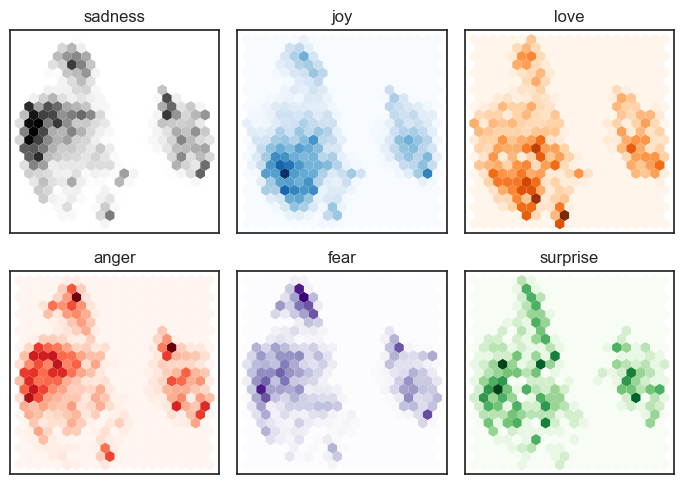

In [32]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(7, 5))  # Fixed: "plt.subplot" to "plt.subplots"
axes = axes.flatten()  # Flatten axes for easy iteration
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']  # Define colormaps
labels = emotions['train'].features['label'].names  # Get the label names from the dataset

# Iterate through labels and colormaps
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_sub = df.query(f'label=={i}')  # Filter data for the current label
    axes[i].hexbin(df_sub['X'], df_sub['Y'], cmap=cmap,
                   gridsize=20, linewidths=0)  # Fixed: No parentheses for linewidths
    axes[i].set_title(label)  # Set the title for the current subplot
    axes[i].set_xticks([])  # Remove x-axis ticks
    axes[i].set_yticks([])  # Remove y-axis ticks

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


This plot reveals some interesting patterns: negative emotions, such as sadness, anger, and fear, tend to occupy nearby regions, with slightly distinct distributions. In contrast, joy and love appear well separated from the negative emotions, sharing a similar area. Meanwhile, the emotion of surprise is scattered throughout the plot.

Although a clearer separation between emotions would have been desirable, this is not guaranteed, as the model was not explicitly trained to differentiate them. It only acquired this understanding implicitly while attempting to predict masked words in the text.

With these insights into the features of our dataset, we are now ready to train a model on it.

#### Training the Model

We've observed that hidden states vary somewhat between emotions, although for several of them, there is no clear boundary. Let's use these hidden states to train a Gradient Boost. Note that using a GPU is not necessary here.

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

gb = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())
gb.fit(X_train, y_train)
score = gb.score(X_valid, y_valid)
y_preds = gb.predict(X_valid)

print(f"Validation Accuracy: {score:.4f}")


Validation Accuracy: 0.5815


At first glance, the model's accuracy may seem only slightly better than that of a random model. However, considering that we are dealing with an imbalanced multiclass dataset, its performance is significantly better. To evaluate whether our model is truly effective, we can compare it to a simple baseline. In Scikit-learn, there is the `DummyClassifier`, which allows you to create a classifier with basic heuristics, such as always choosing the majority class or randomly selecting a class. In this case, the most effective heuristic is to always select the most frequent class, which yields an accuracy of approximately $35\%$.

In [34]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Therefore, our simple classifier with DistilBERT embeddings performs significantly better than the baseline. We can further analyze the model's performance by examining the confusion matrix, which reveals the relationship between the true and predicted labels.

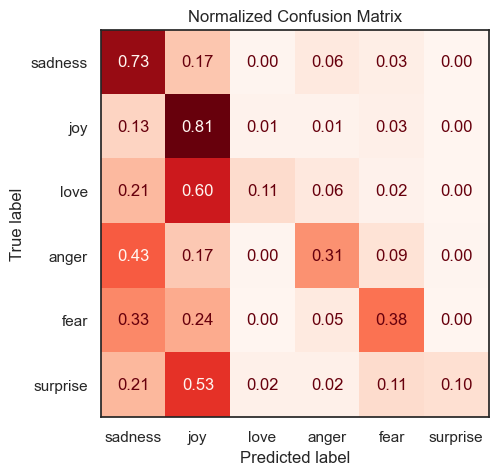

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plotting_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(5, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Reds', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
#y_preds = svm.predict(X_valid)
plotting_matrix(y_preds, y_valid, labels)


From the confusion matrix, we can observe that **anger** and **fear** are often misclassified as **sadness**, aligning with our earlier observations when visualizing the embeddings. Similarly, **love** and **surprise** are frequently mistaken for **joy**.

In the next section we will explored the fine-tuning approch, which leads to superior classification performance.

#### Fine-Tuning

Now, let's explore what is required to perform fine-tuning of a transformer model end-to-end. Unlike using hidden states as fixed features, in fine-tuning, these states are dynamically adjusted during training, as shown in the figure (See--). For this to work, the classification layer must be differentiable, meaning it must allow the computation of gradients. This is essential because training transformer-based models relies on backpropagation, a method that depends on gradient propagation through the layers to update the model's weights. For this reason, the fine-tuning approach typically employs neural networks, which are specifically designed to be fully differentiable and optimizable.

Postar a imagem aqui




legenda: When using the fine-tunning approach the whole DistilBERT model is trained along with the classification model.

Training the hidden states that serve as inputs to the classification model helps avoid the issue of working with data that may not be well-suited for the classification task. During this process, the initial hidden states are adjusted throughout training to minimize the model's loss, which in turn improves its performance.

#### Loading a Pretrained Model

The first step is to obtain a pretrained DistilBERT model, similar to the one we used in the feature-based approach. The only difference is that, in this case, we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The main advantage of `AutoModelForSequenceClassification` is that it already includes a classification head attached to the outputs of the pretrained model, allowing it to be easily trained alongside the base model. We simply need to specify the number of labels the model needs to predict (six in our case), as this determines the number of outputs for the classification head.

In [36]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.\
         from_pretrained(model_ckpt, num_labels=num_labels).\
            to(device))

A warning may appear indicating that certain parts of the model have been randomly initialized. This is expected, as the classification head has not been trained yet. The next step is to define the metrics that will be used to evaluate the model's performance throughout the fine-tuning process.

We will create a function called `metrics()` to monitor the metrics during the model's training. This function will return a dictionary that maps each metric's name to its corresponding value. For our application, we will calculate metrics such as the F1-score and accuracy.

In [37]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):  
    labels = pred.label_ids  # Retrieves the true labels from the EvalPrediction object
    preds = pred.predictions.argmax(-1) # Converts the predictions into label indices by selecting the highest probability
    f1_s = f1_score(labels, preds, average='weighted') #Calculates the weighted F1-score based on the true labels and predictions
    accuracy = accuracy_score(labels, preds)  #Calculates the accuracy by comparing the true labels with the predictions
    return {'Accuracy': accuracy, 'F1-Score': f1_s} # Returns a dictionary with accuracy and F1-score as metrics

In [39]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:

from transformers import Trainer, TrainingArguments

# Define batch size
batch_size = 64

# Calculate logging steps based on the training dataset size
logging_steps = len(emotions_encoded["train"]) // batch_size

# Set model name for saving
model_name = f"{model_ckpt}-finetuned-emotion"

# Define training arguments
training_args = TrainingArguments(
    output_dir=model_name,                  # Directory to save model artifacts
    num_train_epochs=2,                     # Number of training epochs
    learning_rate=2e-5,                     # Learning rate
    per_device_train_batch_size=batch_size, # Batch size for training
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    weight_decay=0.01,                      # Weight decay for regularization
    evaluation_strategy="epoch",            # Evaluation strategy
    disable_tqdm=False,                     # Disable tqdm progress bar
    logging_steps=logging_steps,            # Steps between logging
    push_to_hub=True,                       # Push the model to the Hugging Face Hub
    log_level="error"                       # Log level
)


In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,  # Model to be trained
    args=training_args,  # Training arguments
    compute_metrics=compute_metrics,  # Metrics computation function
    train_dataset=emotions_encoded["train"],  # Training dataset
    eval_dataset=emotions_encoded["validation"],  # Validation dataset
    tokenizer=tokenizer  # Tokenizer associated with the model
)

# Start training
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,0.833000,0.319778,0.905000,0.904577
2,0.253700,0.225113,0.925000,0.924972


TrainOutput(global_step=500, training_loss=0.543361442565918, metrics={'train_runtime': 460.3027, 'train_samples_per_second': 69.519, 'train_steps_per_second': 1.086, 'total_flos': 720342861696000.0, 'train_loss': 0.543361442565918, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output.metrics

{'test_loss': 0.22511282563209534,
 'test_Accuracy': 0.925,
 'test_F1-Score': 0.9249723686928089,
 'test_runtime': 9.1613,
 'test_samples_per_second': 218.31,
 'test_steps_per_second': 3.493}

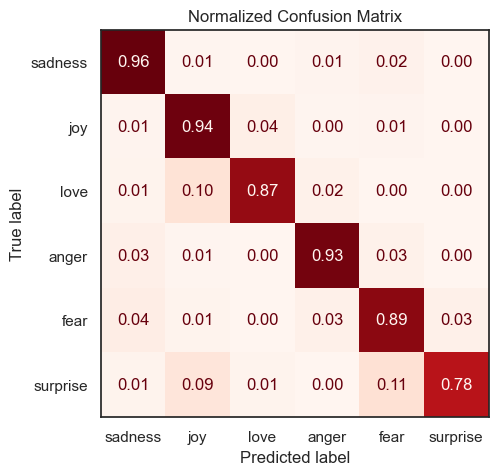

In [44]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plotting_matrix(y_preds, y_valid, labels)